# Machine Learning Model

In [ ]:
!pip install xlrd==2.0.1

In [1]:
# Import necessary libraries
import pandas as pd
import os
import zipfile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Extract and Load Data
zip_file_path = 'Give Me Some Credit.zip'
extract_folder = 'give_me_some_credit_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

train_data = pd.read_csv(os.path.join(extract_folder, 'cs-training.csv'))
test_data = pd.read_csv(os.path.join(extract_folder, 'cs-test.csv'))

In [3]:
# Data Inspection and Cleaning
# Impute missing values for MonthlyIncome (median) and NumberOfDependents (0)
imputer_income = SimpleImputer(strategy="median")
train_data['MonthlyIncome'] = imputer_income.fit_transform(train_data[['MonthlyIncome']])
train_data['NumberOfDependents'].fillna(0, inplace=True)

# Treat age outliers by capping at a minimum of 18
train_data['age'] = train_data['age'].apply(lambda x: max(x, 18))

# Drop unnecessary columns (index column)
X = train_data.drop(columns=['SeriousDlqin2yrs', 'Unnamed: 0'])
y = train_data['SeriousDlqin2yrs']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\milto\AppData\Local\Temp\ipykernel_1704\2100365674.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['NumberOfDependents'].fillna(0, inplace=True)


In [4]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
# Define Models and Hyperparameters
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [5, 10]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [5, 10, 20]
    }
}

In [6]:
# Step 5: Train and Evaluate Each Model
results = []

for model_name, model in models.items():
    if model_name == "SVM":  # Skip SVM for computational reasons
        print(f"Skipping {model_name}...")
        continue
    
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    auc_score = roc_auc_score(y_val, y_pred_proba)
    
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}\n")
    
    results.append((model_name, best_model, accuracy, auc_score))

Training Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.9386, AUC: 0.8628

Training Gradient Boosting...
Best Parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Accuracy: 0.9382, AUC: 0.8637

Training Logistic Regression...
Best Parameters for Logistic Regression: {'C': 0.1}
Accuracy: 0.9351, AUC: 0.6937

Skipping SVM...
Training K-Nearest Neighbors...
Best Parameters for K-Nearest Neighbors: {'n_neighbors': 20}
Accuracy: 0.9357, AUC: 0.7479



In [7]:
# Step 6: Compare Model Performance
results_df = pd.DataFrame(results, columns=["Model", "Best Estimator", "Accuracy", "AUC"])
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                 Model                                     Best Estimator  \
0        Random Forest  (DecisionTreeClassifier(max_depth=10, max_feat...   
1    Gradient Boosting  ([DecisionTreeRegressor(criterion='friedman_ms...   
2  Logistic Regression  LogisticRegression(C=0.1, max_iter=1000, rando...   
3  K-Nearest Neighbors               KNeighborsClassifier(n_neighbors=20)   

   Accuracy       AUC  
0  0.938600  0.862840  
1  0.938200  0.863701  
2  0.935067  0.693702  
3  0.935700  0.747881  


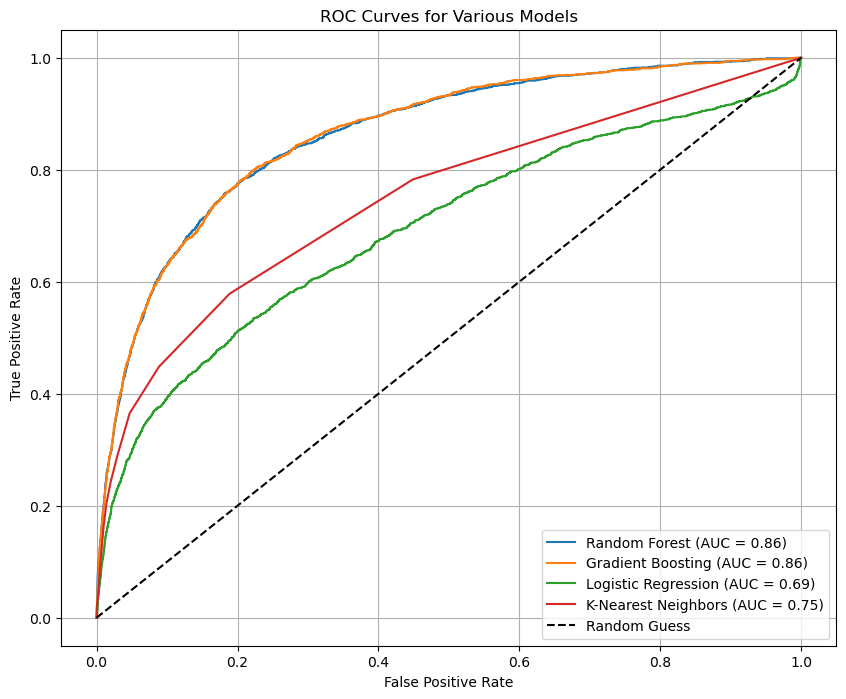

In [8]:
# Step 7: Visualize ROC Curves for All Models
plt.figure(figsize=(10, 8))
for model_name, best_model, _, _ in results:
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_val, y_pred_proba):.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Various Models")
plt.legend()
plt.grid()
plt.show()


Synthetic Test Data Predictions (Gradient Boosting):
   RevolvingUtilizationOfUnsecuredLines  age  \
0                              0.347260   24   
1                              0.749434   37   
2                              0.538632   72   
3                              0.537872   84   
4                              0.762139   32   
5                              0.859134   64   
6                              0.886470   45   
7                              0.577779   88   
8                              0.981782   37   
9                              0.136059   92   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     1   0.978359   11755.545130   
1                                     4   0.335782    5628.362491   
2                                     2   0.500626   13048.090329   
3                                     7   1.042862    1098.674323   
4                                     4   1.626081    1433.838786   
5  

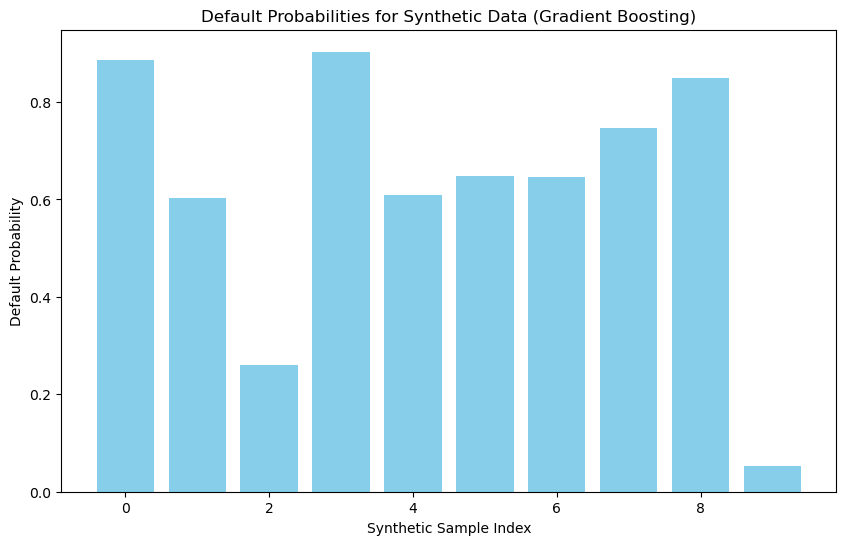

In [10]:
# Make a Prediction

import numpy as np

# Get the feature names used during training
train_features = list(X.columns)  # These are the features used for training

# Define synthetic data, matching only the features used in training
synthetic_data = {
    'RevolvingUtilizationOfUnsecuredLines': np.random.uniform(0, 1, 10),  # Example range: 0-1
    'age': np.random.randint(18, 100, 10),  # Example range: 18-100
    'NumberOfTime30-59DaysPastDueNotWorse': np.random.randint(0, 10, 10),  # Example range: 0-10
    'DebtRatio': np.random.uniform(0, 2, 10),  # Example range: 0-2
    'MonthlyIncome': np.random.uniform(1000, 20000, 10),  # Example range: 1000-20000
    'NumberOfOpenCreditLinesAndLoans': np.random.randint(1, 20, 10),  # Example range: 1-20
    'NumberOfTimes90DaysLate': np.random.randint(0, 10, 10),  # Example range: 0-10
    'NumberRealEstateLoansOrLines': np.random.randint(0, 10, 10),  # Example range: 0-10
    'NumberOfDependents': np.random.randint(0, 5, 10),  # Example range: 0-5
}

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Align synthetic data with training features
for col in train_features:
    if col not in synthetic_df.columns:
        synthetic_df[col] = 0  # Add missing columns with default values
synthetic_df = synthetic_df[train_features]  # Align feature order

# Standardize the synthetic data using the same scaler as the training data
synthetic_scaled = scaler.transform(synthetic_df)

# Use the best-performing model from results_df
best_model_row = results_df.loc[results_df['AUC'].idxmax()]
best_model = best_model_row['Best Estimator']
best_model_name = best_model_row['Model']

# Predict default risk using the best model
predictions = best_model.predict(synthetic_scaled)
predicted_probabilities = best_model.predict_proba(synthetic_scaled)[:, 1]

# Combine predictions with synthetic data
synthetic_df['Predicted Default Risk'] = predictions
synthetic_df['Default Probability'] = predicted_probabilities

# Display synthetic test data with predictions
print(f"\nSynthetic Test Data Predictions ({best_model_name}):")
print(synthetic_df)

# Visualization: Default Probabilities
plt.figure(figsize=(10, 6))
plt.bar(range(len(predicted_probabilities)), predicted_probabilities, color='skyblue')
plt.title(f'Default Probabilities for Synthetic Data ({best_model_name})')
plt.xlabel('Synthetic Sample Index')
plt.ylabel('Default Probability')
plt.show()

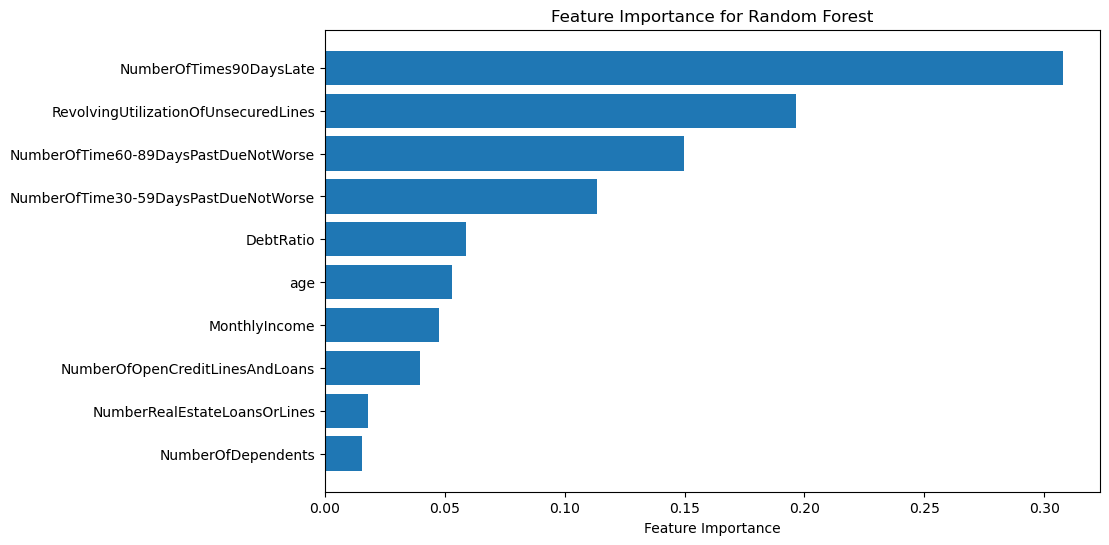

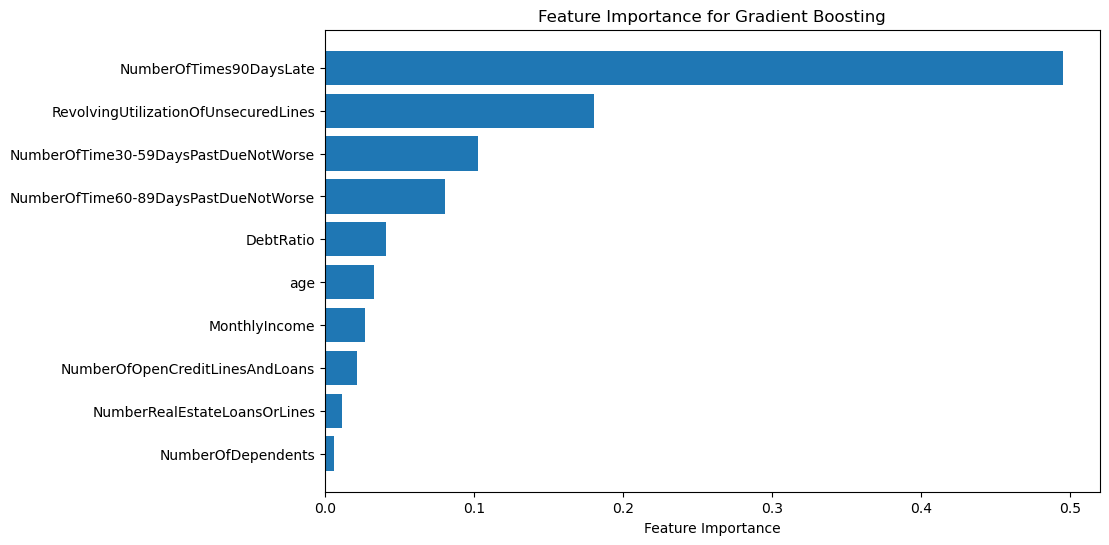

In [11]:
# Step 8: Feature Importance for Tree-Based Models
for model_name, best_model, _, _ in results:
    if hasattr(best_model, 'feature_importances_'):
        feature_importances = best_model.feature_importances_
        features = X.columns
        sorted_indices = feature_importances.argsort()

        plt.figure(figsize=(10, 6))
        plt.barh(features[sorted_indices], feature_importances[sorted_indices])
        plt.xlabel("Feature Importance")
        plt.title(f"Feature Importance for {model_name}")
        plt.show()

In [ ]:
# https://www.kaggle.com/datasets/brycecf/give-me-some-credit-dataset

In [ ]:
# Key Ideas

# Model's Behavior:
# The model tends to classify individuals with higher DebtRatio, RevolvingUtilizationOfUnsecuredLines, and a history of late payments (NumberOfTimes90DaysLate) as higher risk.
# Row 3: High DebtRatio (1.04), significant late payment history (NumberOfTimes90DaysLate = 7), and low MonthlyIncome lead to a high probability (0.90) of default.
# Row 9: Despite a high DebtRatio (1.99), no late payment history (NumberOfTimes90DaysLate = 0) contributes to a low probability (0.05) of default.

# Notable Observations:
#Y oung Age and Risk: Row 0: A 24-year-old is predicted high risk with a probability of 0.88, potentially due to other financial factors.
# Elderly and Low Risk: Row 9: A 92-year-old with no significant late payment history is classified as low risk (probability of 0.05), despite high debt ratios.

In [ ]:
# Skills to describe:
# Enhancements Made:
# Multiple Models: Added Logistic Regression, Gradient Boosting, SVM, and K-Nearest Neighbors to compare performance.
# Hyperparameter Tuning: Used GridSearchCV to optimize hyperparameters for each model.
# Model Comparison: Displayed a summary table of model performance metrics (Accuracy and AUC).
# Visualizations:
# ROC curves for all models.
# Feature importance for tree-based models.

# This approach ensures that your portfolio showcases:
# Knowledge of multiple ML algorithms.
# Ability to perform hyperparameter tuning.
# Skills in model evaluation and visualization.  